In [1]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.python.ops.numpy_ops import np_config
from sklearn.metrics import mean_squared_error

In [2]:
# enable numpy behavior
np_config.enable_numpy_behavior()

In [3]:
data_path = 'mitdb/'

In [4]:
# Get the list of all record files in the folder
# List of Patients
data = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

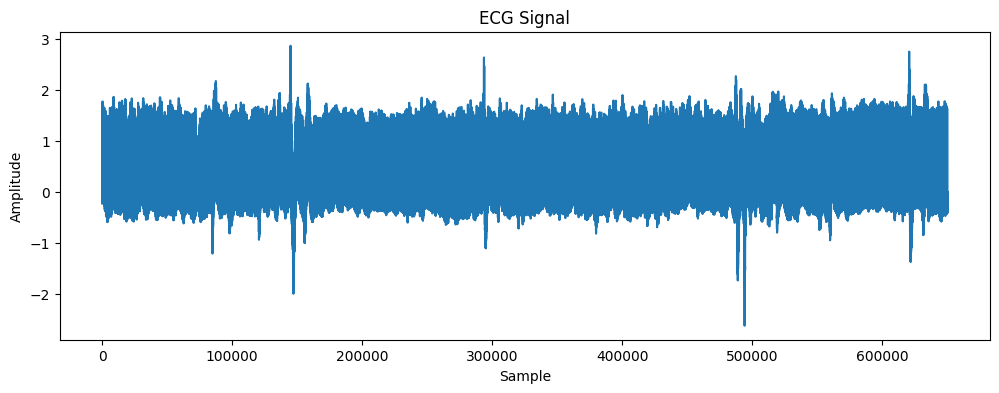

In [5]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate, signal
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}
    
    # Calculate mean of the signal
    features['mean'] = np.mean(signal)
    
    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)
    
    # Calculate maximum value of the signal
    features['max'] = np.max(signal)
    
    # Calculate minimum value of the signal
    features['min'] = np.min(signal)
    
    # Calculate median value of the signal
    features['median'] = np.median(signal)
    
    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)
    
    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)
    
    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)

In [7]:
sign = sig_filtered, sig_denoised, sig_dilated, sig_eroded, sig_opened

In [8]:
# Inisialisasi KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Fungsi untuk menghitung Signal-to-Noise Ratio (SNR)
def calculate_snr(clean_data, denoised_data):
    noise = clean_data - denoised_data
    signal_power = np.sum(clean_data ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [10]:
# Fungsi untuk menghitung Root Mean Square Error (RMSE)
def calculate_rmse(clean_data, denoised_data):
    mse = mean_squared_error(clean_data.flatten(), denoised_data.flatten())
    rmse = np.sqrt(mse)
    return rmse

In [11]:
# Membangun model Deep RNN Autoencoder
def build_autoencoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # Encoder
    encoder = LSTM(latent_dim, return_sequences=True)(inputs)
    encoder = LSTM(latent_dim)(encoder)

    # Decoder
    decoder = RepeatVector(input_shape[0])(encoder)
    decoder = LSTM(latent_dim, return_sequences=True)(decoder)
    decoder = TimeDistributed(Dense(input_shape[1]))(decoder)

    # Membuat model autoencoder
    autoencoder = Model(inputs, decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [12]:
sign_array = np.array(sign[3])
sign = np.squeeze(sign_array)  # Reshape the array to remove the singleton dimension

In [13]:
result_snr = []
result_rmse = []
list_denoised_data = []
i = 1
for train, test in kfold.split(sign):
    # Print index data train dan test
    print("Train: ", train, "Test: ", test)
    # Print isi data train dan test
    print("Train data: ", sig[train], "Test data: ", sig[test])

    # Mendapatkan data train dan test
    X_train, X_test = sign[train], sign[test]

    # Pra-pemrosesan data
    X_train = (X_train - np.mean(X_train)) / np.std(X_train)
    X_test = (X_test - np.mean(X_test)) / np.std(X_test)

    # Mengubah dimensi input ke bentuk yang diharapkan oleh layer LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

    # Menentukan dimensi input
    input_shape = X_train.shape[1:]

    # Menentukan dimensi latent space
    latent_dim = 128

    # Membangun model autoencoder
    autoencoder = build_autoencoder(input_shape, latent_dim)
    
    # Define early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

    # Melatih model
    autoencoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test), callbacks=[early_stop])

    # Melakukan denoising pada data test
    denoised_data = autoencoder.predict(X_test)

    # Menghitung SNR dan RMSE
    snr = calculate_snr(X_test, denoised_data)
    print(snr)
    rmse = calculate_rmse(X_test, denoised_data)

    # Tampilkan hasil SNR dan RMSE
    print(f'Signal to Noise Ratio (SNR) fold-{i}:', snr)
    print(f'Root Mean Squared Error (RMSE) fold-{i}:', rmse)

    result_snr.append(snr)
    result_rmse.append(rmse)
    list_denoised_data.append(denoised_data)
    i += 1

Train:  [     1      2      3 ... 162496 162497 162498] Test:  [     0      4     12 ... 162488 162493 162499]
Train data:  [ 0.23942199  0.23942199  0.23942199 ... -0.59026283 -0.61989443
 -0.61989443] Test data:  [ 0.23942199  0.23942199  0.31350099 ... -0.45692063 -0.53099963
 -0.59026283]
Epoch 1/100
1016/1016 [==============================] - 12s 7ms/step - loss: 0.0258 - val_loss: 2.8597e-05
Epoch 2/100
1016/1016 [==============================] - 7s 6ms/step - loss: 1.4397e-05 - val_loss: 9.6230e-06
Epoch 3/100
1016/1016 [==============================] - 7s 6ms/step - loss: 1.1273e-05 - val_loss: 5.6356e-06
Epoch 4/100
1016/1016 [==============================] - 7s 6ms/step - loss: 1.0763e-05 - val_loss: 2.3457e-05
Epoch 5/100
1016/1016 [==============================] - 7s 6ms/step - loss: 1.4151e-05 - val_loss: 3.6480e-06
Epoch 6/100
1016/1016 [==============================] - 7s 6ms/step - loss: 2.0272e-05 - val_loss: 4.7879e-06
Epoch 7/100
1016/1016 [====================

In [14]:
k = 1
for i in range(len(result_snr)):
    print(f"Hasil SNR ke-{k}:", result_snr[i])
    k += 1

Hasil SNR ke-1: 71.2766628891138
Hasil SNR ke-2: 73.83001690489797
Hasil SNR ke-3: 73.37448826258299
Hasil SNR ke-4: 67.6732956020038
Hasil SNR ke-5: 76.14796398316886


In [15]:
k = 1
for i in range(len(result_rmse)):
    print(f"Hasil rmse ke-{k}:", result_rmse[i])
    k += 1

Hasil rmse ke-1: 0.0002730026455022684
Hasil rmse ke-2: 0.00020346942358264478
Hasil rmse ke-3: 0.0002144250830067815
Hasil rmse ke-4: 0.0004133664450095919
Hasil rmse ke-5: 0.00015581232240593167


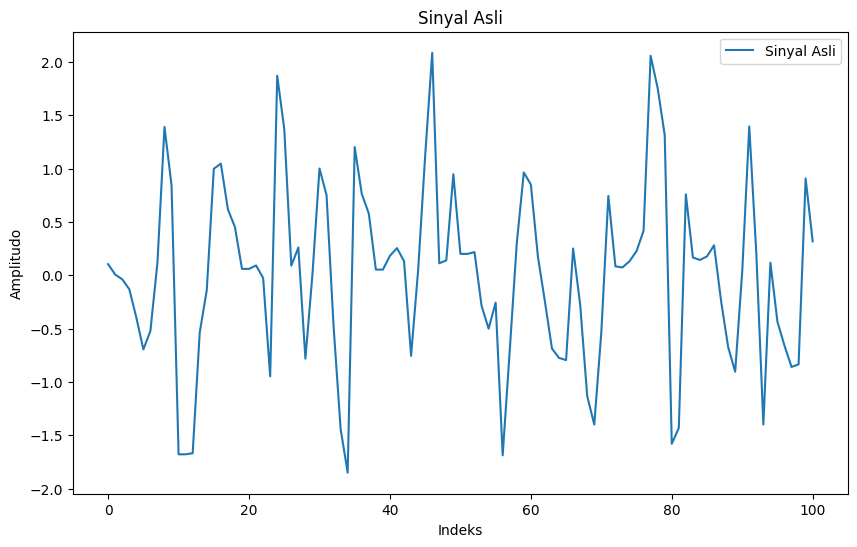

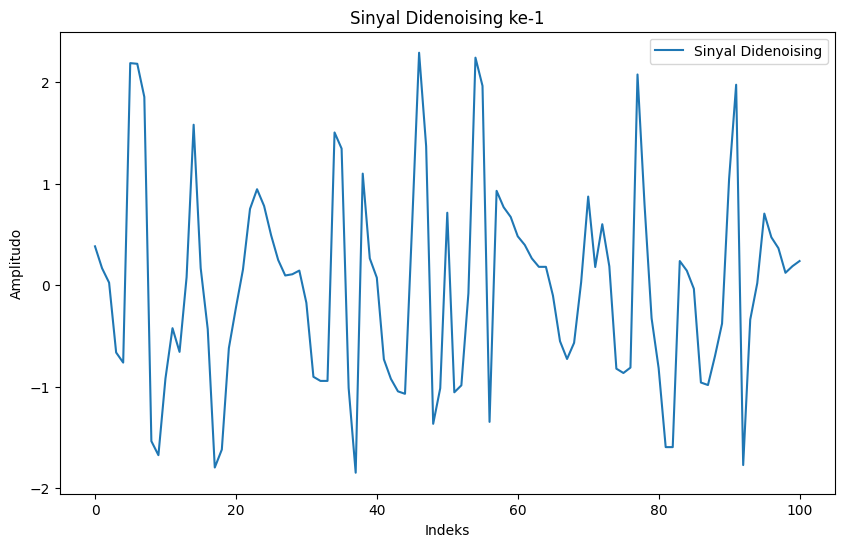

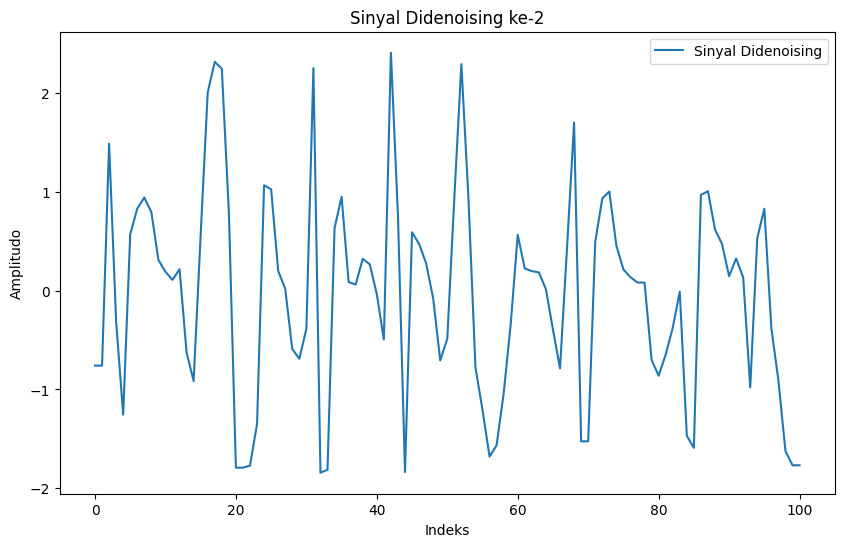

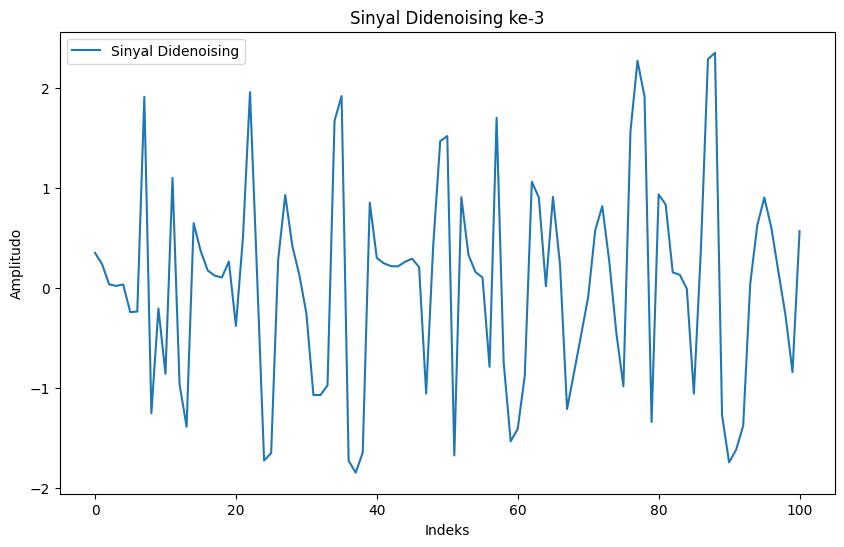

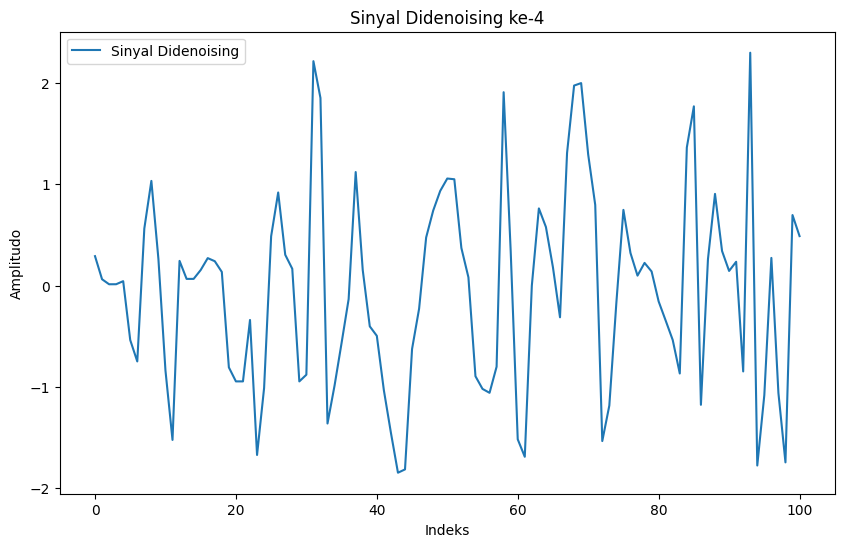

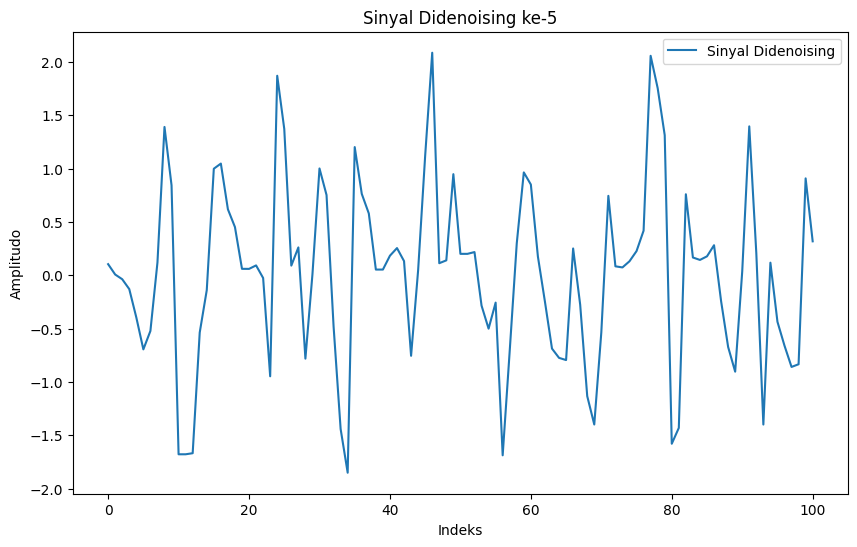

In [16]:
import matplotlib.pyplot as plt

# Memilih salah satu fold
fold_index = 0

# Mendapatkan sinyal asli dan sinyal yang telah didenoising dari fold yang dipilih
asli = np.max(X_test, axis=1)


# Menampilkan plot sinyal asli
plt.figure(figsize=(10, 6))
plt.plot(asli[0:101], label='Sinyal Asli')
plt.xlabel('Indeks')
plt.ylabel('Amplitudo')
plt.title('Sinyal Asli')
plt.legend()
plt.show()

k = 1
for i in range(len(list_denoised_data)):
    denoised = np.max(list_denoised_data[i], axis=1)
    # Menampilkan plot sinyal yang telah didenoising
    plt.figure(figsize=(10, 6))
    plt.plot(denoised[0:101], label='Sinyal Didenoising')
    plt.xlabel('Indeks')
    plt.ylabel('Amplitudo')
    plt.title(f'Sinyal Didenoising ke-{k}')
    plt.legend()
    plt.show()
    k += 1

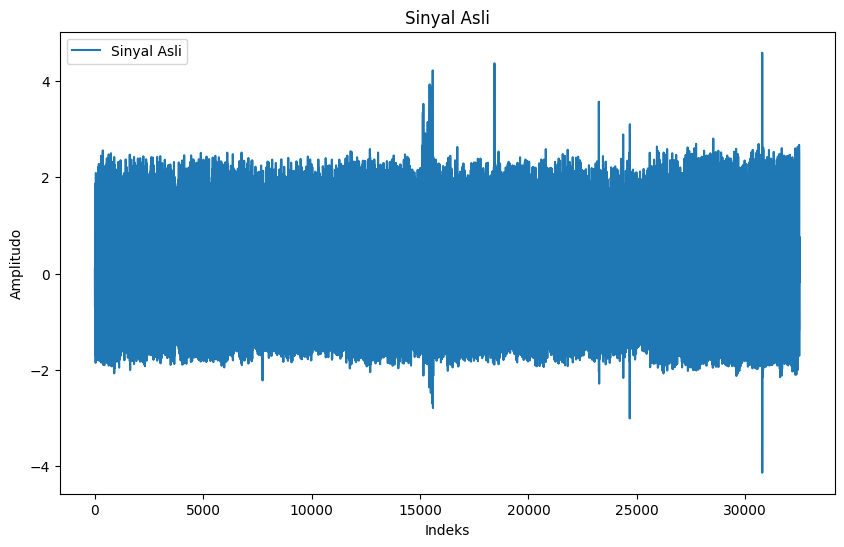

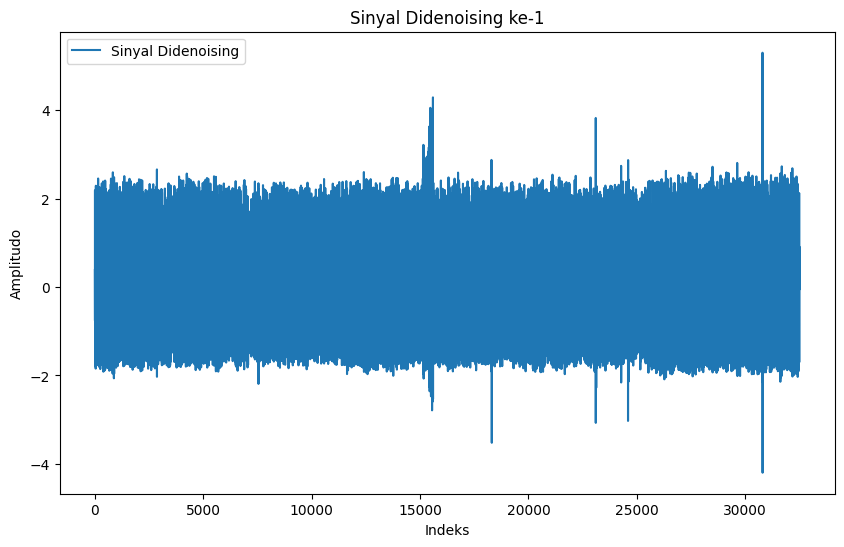

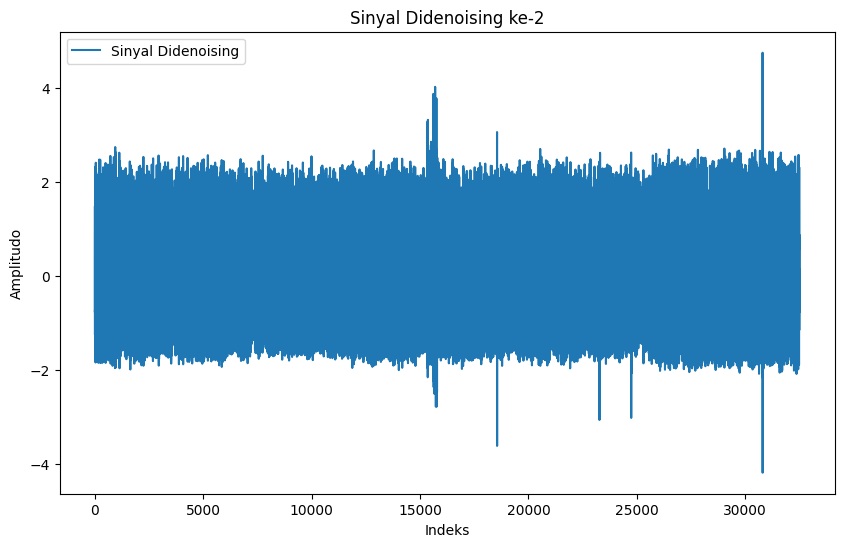

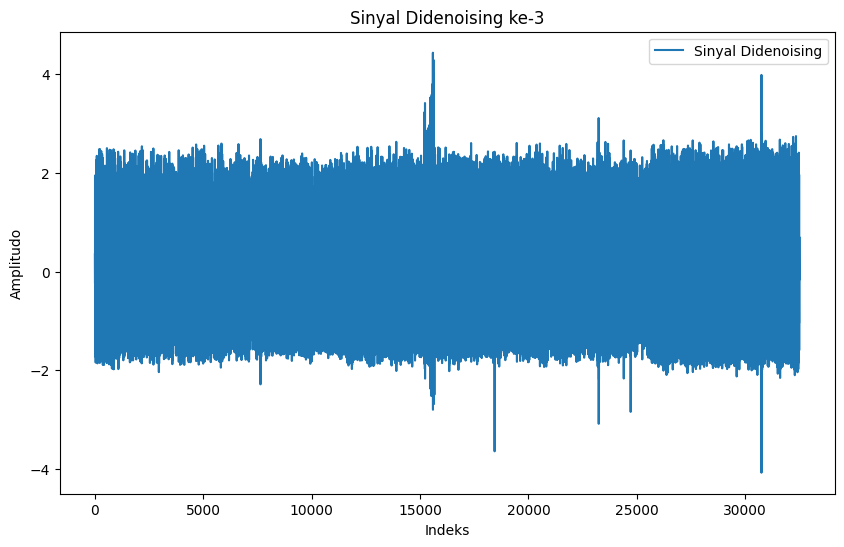

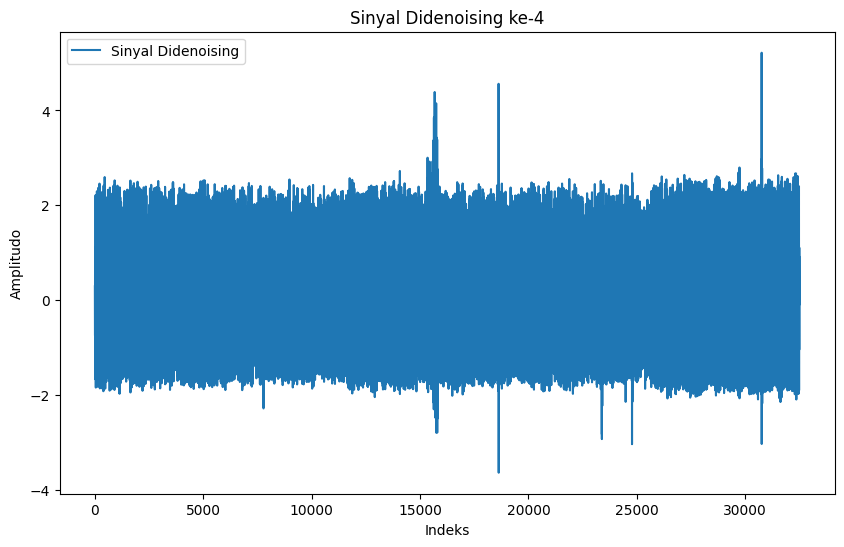

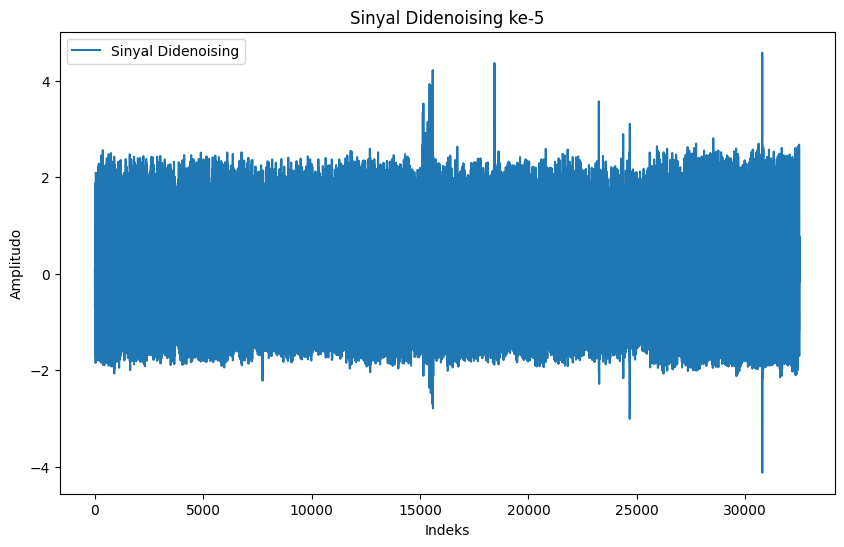

In [17]:
import matplotlib.pyplot as plt

# Memilih salah satu fold
fold_index = 0

# Mendapatkan sinyal asli dan sinyal yang telah didenoising dari fold yang dipilih
asli = np.max(X_test, axis=1)


# Menampilkan plot sinyal asli
plt.figure(figsize=(10, 6))
plt.plot(asli, label='Sinyal Asli')
plt.xlabel('Indeks')
plt.ylabel('Amplitudo')
plt.title('Sinyal Asli')
plt.legend()
plt.show()

k = 1
for i in range(len(list_denoised_data)):
    denoised = np.max(list_denoised_data[i], axis=1)
    # Menampilkan plot sinyal yang telah didenoising
    plt.figure(figsize=(10, 6))
    plt.plot(denoised, label='Sinyal Didenoising')
    plt.xlabel('Indeks')
    plt.ylabel('Amplitudo')
    plt.title(f'Sinyal Didenoising ke-{k}')
    plt.legend()
    plt.show()
    k += 1
